<a href="https://colab.research.google.com/github/yuvrajdevrukhkar/DLLab/blob/main/prac6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection using Transfer Learning of CNN architectures


In [1]:
# import Required libraries
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
# load data
# Explore more about datset: https://www.tensorflow.org/datasets/catalog/tf_flowers
# Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

In [3]:
# Image processing

# check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [4]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [5]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

**a. Load in a pre-trained CNN model trained on a large dataset**

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [7]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 2s 0us/step


**b. Freeze parameters(weights) in the model’s lower convolutional layers**

In [8]:
base_model.trainable = False

In [9]:
## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [10]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

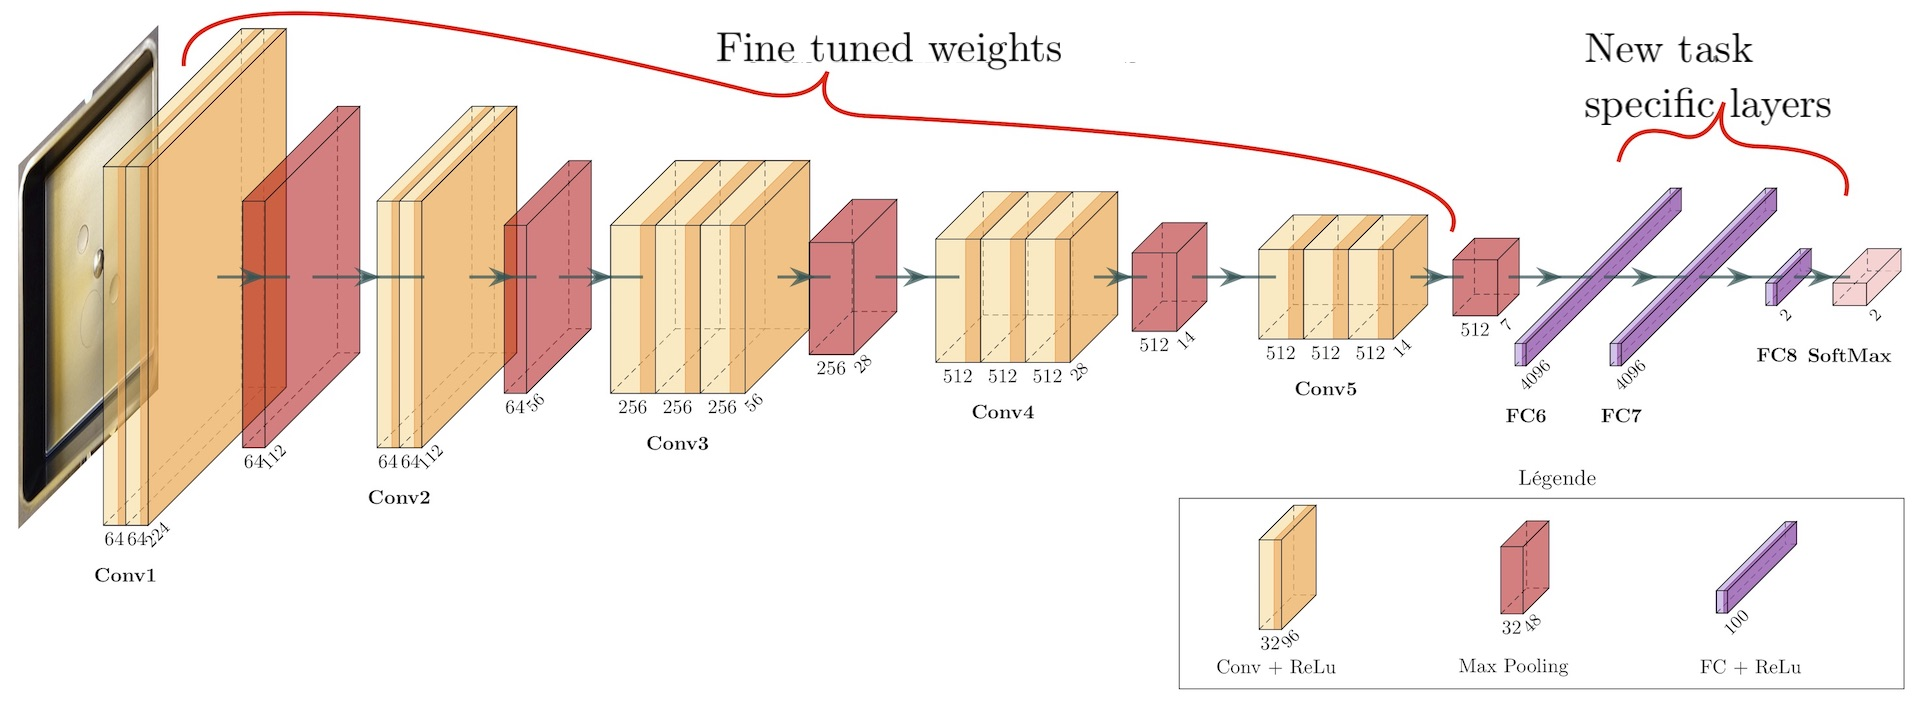

**c. Add a custom classifier with several layers of trainable parameters to model**

In [11]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**d. Train classifier layers on training data available for the task**

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history=model.fit(train_ds, train_labels, epochs=2, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/2
65/65 [==============================] - 19s 118ms/step - loss: 1.9377 - accuracy: 0.4443 - val_loss: 1.1443 - val_accuracy: 0.5564
Epoch 2/2
65/65 [==============================] - 6s 86ms/step - loss: 0.9175 - accuracy: 0.6613 - val_loss: 0.9693 - val_accuracy: 0.6265


In [13]:
test_loss, test_accuracy = model.evaluate(test_ds,test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

35/35 [==============================] - 4s 104ms/step - loss: 0.6965 - accuracy: 0.7548
Test loss: 0.6964541077613831
Test accuracy: 0.7547683715820312
